In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    FunctionTransformer,
)

# Models
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor,
    VotingRegressor,
)
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

# Model Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    learning_curve,
)

# Metrics and Others
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [4]:
df = pd.DataFrame()  # Initialize an empty DataFrame to store the combined data
files = [
    "./data/audi.csv",
    "./data/toyota.csv",
    "./data/skoda.csv",
    "./data/ford.csv",
    "./data/vauxhall.csv",
    "./data/bmw.csv",
    "./data/vw.csv",
    "./data/merc.csv",
]

for file in files:
    temp_df = pd.read_csv(file)
    temp_df["brand"] = os.path.basename(file).split(".")[0]
    df = pd.concat([df, temp_df], ignore_index=True)
hyundi = pd.read_csv("./data/hyundi.csv")
hyundi = hyundi.rename(columns={"tax(£)": "tax"})
hyundi["brand"] = "hyundi"
df = pd.concat([df, hyundi], ignore_index=True)

# Exploratory Data Analysis

In [5]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0,audi


In [6]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000,99187.000000
mean,2017.087723,16805.347656,23058.914213,120.299838,55.166825,1.663280
std,2.123934,9866.773417,21148.523721,63.150926,16.138522,0.557646
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,9999.000000,7425.000000,125.000000,47.100000,1.200000
50%,2017.000000,14495.000000,17460.000000,145.000000,54.300000,1.600000
75%,2019.000000,20870.000000,32339.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [7]:
df.isna().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
brand           0
dtype: int64

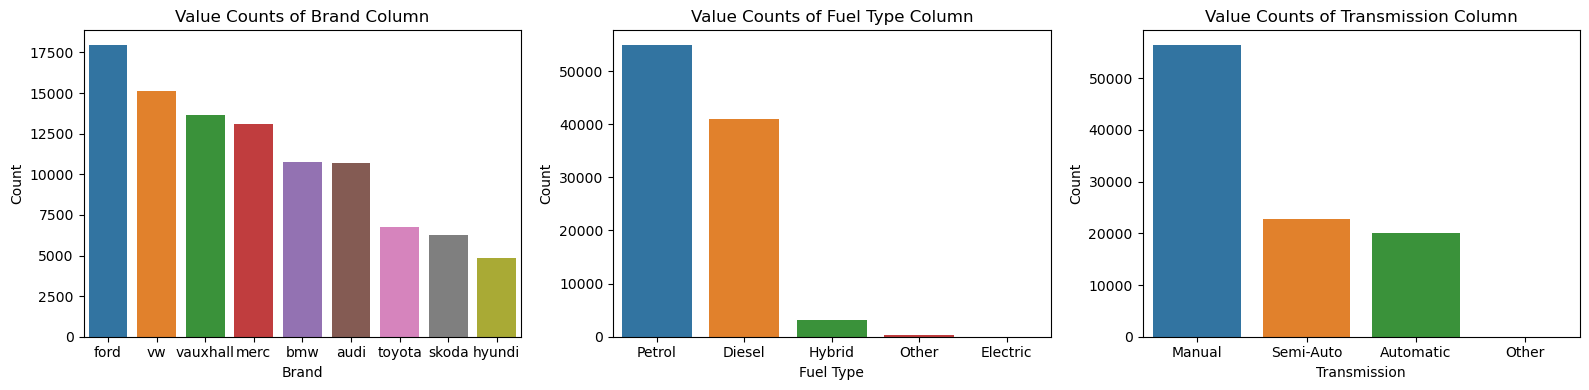

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sns.barplot(
    y=df["brand"].value_counts().values, x=df["brand"].value_counts().index, ax=axes[0]
)
axes[0].set_xlabel("Brand")
axes[0].set_ylabel("Count")
axes[0].set_title("Value Counts of Brand Column")

sns.barplot(
    y=df["fuelType"].value_counts().values,
    x=df["fuelType"].value_counts().index,
    ax=axes[1],
)
axes[1].set_xlabel("Fuel Type")
axes[1].set_ylabel("Count")
axes[1].set_title("Value Counts of Fuel Type Column")

sns.barplot(
    y=df["transmission"].value_counts().values,
    x=df["transmission"].value_counts().index,
    ax=axes[2],
)
axes[2].set_xlabel("Transmission")
axes[2].set_ylabel("Count")
axes[2].set_title("Value Counts of Transmission Column")

plt.tight_layout()
plt.show()

Will remove other and electric vehicles as they dont account for much and add more columns. Will also remove other transmissions.

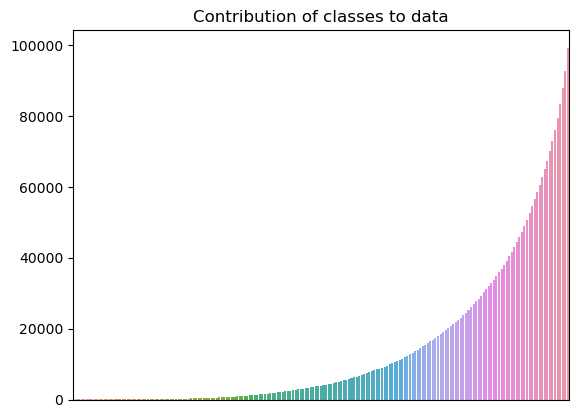

In [9]:
sns.barplot(
    y=df["model"].value_counts()[::-1].cumsum().values,
    x=df["model"].value_counts()[::-1].cumsum().index,
)
plt.xticks([])
plt.title("Contribution of classes to data")
plt.show()

If we remove classes with less than 20000, we will reduce columns by 75% but only lose 25% of the data

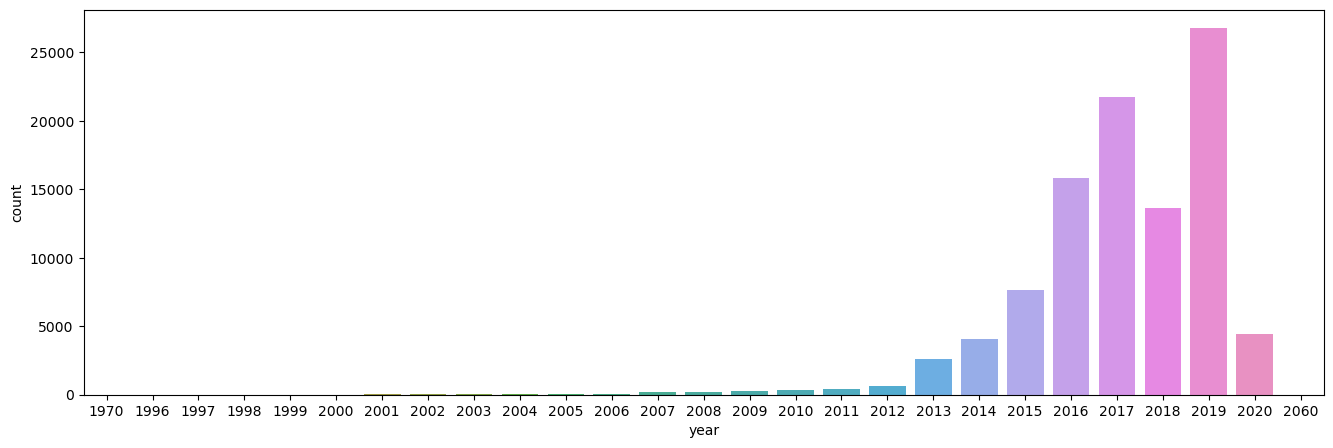

In [10]:
plt.figure(figsize=(16, 5))
sns.countplot(df, x="year")
plt.show()

Again, there is a outlier at 2060. We should convert this into age of car for better acc. 1970 seems abit too old, we will remove it too while keeping 1996 and above. 

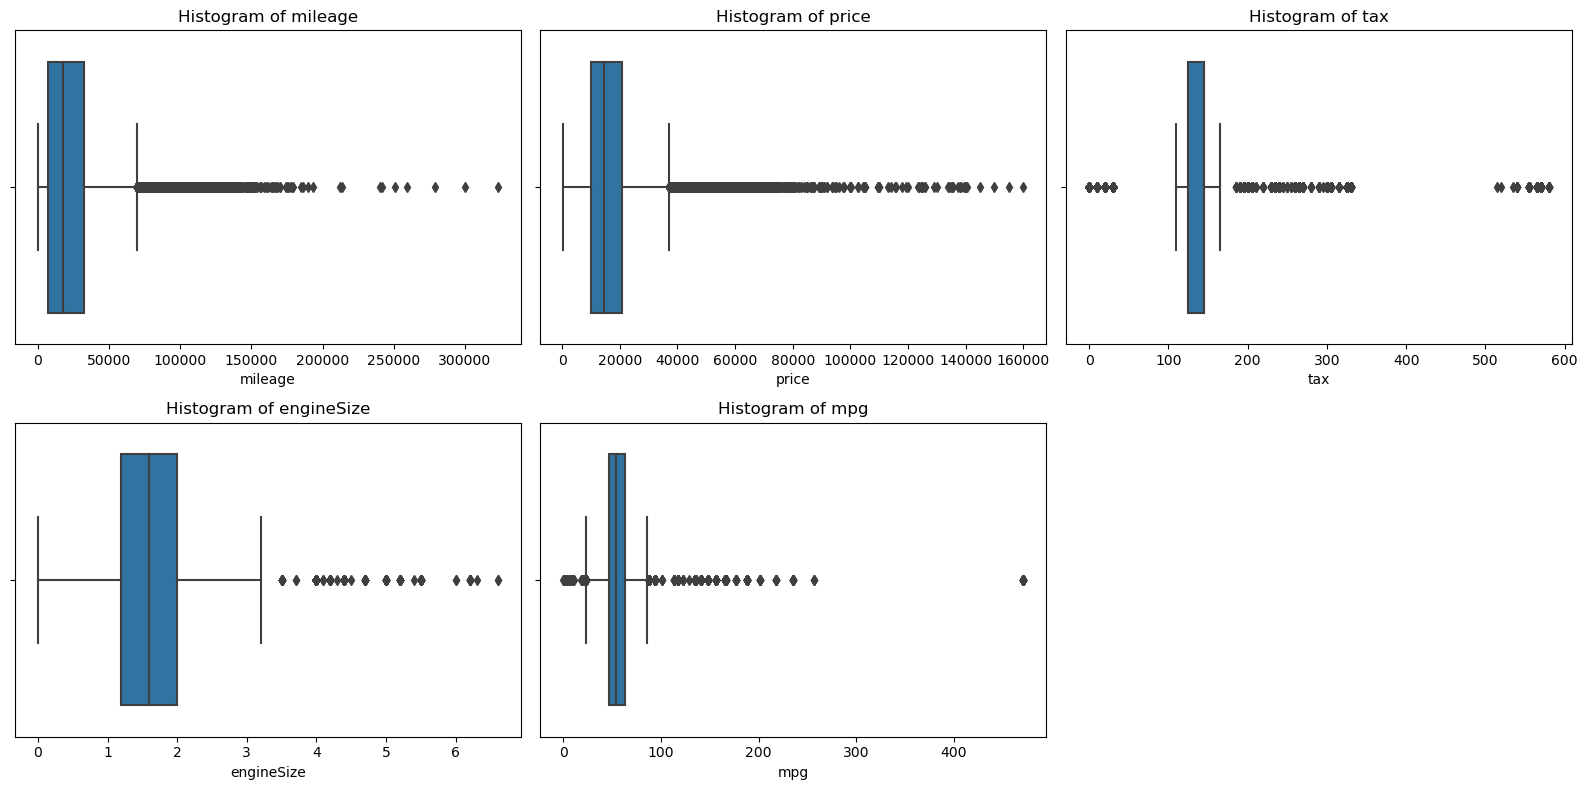

In [11]:
plt.figure(figsize=(16, 8))

selected_data = df[["mileage", "price", "tax", "engineSize", "mpg"]]
for i, column in enumerate(["mileage", "price", "tax"]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=selected_data, x=column)
    plt.title(f"Histogram of {column}")

for i, column in enumerate(["engineSize", "mpg"], 3):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=selected_data, x=column)
    plt.title(f"Histogram of {column}")

plt.tight_layout()
plt.show()

MPG of 400 is a error as the max is usually around 220. Engine size of 0 is also an error as it just sounds wrong. We will remove both. Rest of the columns seem ok but slightly skewed. So might consider log transforming mileage. Tax abit hard to deal with as it has zero. 

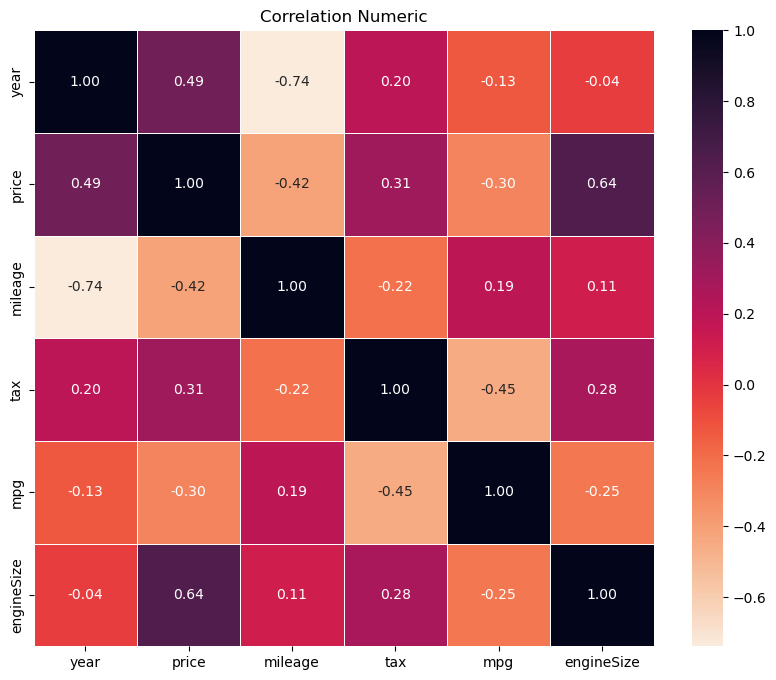

In [12]:
corr_matrix = df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="rocket_r", fmt=".2f", linewidths=0.5)
plt.title("Correlation Numeric")
plt.show()

Most of the predictors do not seem to have high correlation with each other which is good. Price seems to be highly correlated with year and engine size. This makes sense as a newer car and more powerful car would fetch a higher price.

# Cleaning

In [13]:
df = df[~df["fuelType"].isin(["Other", "Electric"])]
df = df[~df["transmission"].isin(["Other"])]
df = df[df["year"] > 1990]
df = df[df["year"] < 2023]
df["year"] = 2023 - df["year"]
df = df[df["engineSize"] != 0]
df = df[df["mpg"] < 300]
df = df[
    ~df["model"].isin(
        df["model"].value_counts()[df["model"].value_counts() < 200].index
    )
]

In [14]:
df.to_hdf("cars.h5", key="cars")

# Preprocessing Pipeline
Here we will one hot the categorical data, scale/log the numeric data and create a new column called age from the year column

In [15]:
df["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid'], dtype=object)

In [16]:
X = df.drop(["price", "model"], axis=1)
y = df["price"]
y = y.values.ravel()

In [17]:
ord_enc = ["transmission"]
onehot_enc = ["brand", "fuelType"]

scale_trans = ["mileage", "tax", "mpg", "engineSize"]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "label_enc",
            OrdinalEncoder(categories=[["Manual", "Semi-Auto", "Automatic"]]),
            ord_enc,
        ),
        ("onehot_enc", OneHotEncoder(), onehot_enc),
        ("scale_trans", StandardScaler(), scale_trans),
    ],
    remainder="passthrough",
)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.70, random_state=99
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, train_size=0.5, random_state=99
)

features = X_train.columns

# Model Evaluation

In [19]:
def getPipe(name, model):
    pipe = Pipeline([("preprocessing", preprocessor), (name, model)])
    return pipe

In [20]:
models = [
    ("AdaBoostRegressor", AdaBoostRegressor()),
    ("Elasticnet", ElasticNet()),
    ("ExtraTreesRegressor", ExtraTreesRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("Lasso", Lasso()),
    ("LinearRegression", LinearRegression()),
    ("RandomForest", RandomForestRegressor()),
    ("Ridge", Ridge()),
]

In [21]:
results = []
for name, model in models:
    pipe = getPipe(name, model)
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict(X_val)

    r2 = r2_score(y_val, y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)

    needed = {"name": name, "r2": r2, "mape": mape}

    results.append(needed)
    print(f"{name}: Done")
result_df = pd.DataFrame(results)
result_df

AdaBoostRegressor: Done
Elasticnet: Done
ExtraTreesRegressor: Done
GradientBoosting: Done
Lasso: Done
LinearRegression: Done
RandomForest: Done
Ridge: Done


,name,r2,mape
0,AdaBoostRegressor,0.561832,0.379821
1,Elasticnet,0.720060,0.229378
2,ExtraTreesRegressor,0.945363,0.082342
3,GradientBoosting,0.901410,0.129191
4,Lasso,0.797757,0.212168
5,LinearRegression,0.797793,0.212352
6,RandomForest,0.949272,0.079728
7,Ridge,0.797782,0.212236


Out of all the models, both extratrees regressor and random forest regressor seem to perform very well. Gradient boosting performed ok.

In [22]:
voting_regressor = VotingRegressor(
    estimators=[
        ("ExtraTreesRegressor", ExtraTreesRegressor()),
        ("GradientBoosting", GradientBoostingRegressor()),
        ("RandomForest", RandomForestRegressor()),
    ]
)
vote_pipe = getPipe("voting_regressor", voting_regressor)
vote_pipe.fit(X_train, y_train)

y_val_pred = vote_pipe.predict(X_val)

r2 = r2_score(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)

print("Voting Regressor")
print(f"R2: {r2}")
print(f"MAPE: {mape}")

Voting Regressor
R2: 0.9488956222712608
MAPE: 0.08500218878528085


Performs slighlty worse than random forest while being more complex. I am very concerned with how long these models take to run. Therefore I would like to use LightGBM which is a fast but effective algorithm.

In [23]:
lgbm_regressor = LGBMRegressor()
lgbm_pipe = getPipe("lgbm_regressor", lgbm_regressor)
lgbm_pipe.fit(X_train, y_train)

y_val_pred = lgbm_pipe.predict(X_val)

r2 = r2_score(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)

print("LightGBM Regressor")
print(f"R2: {r2}")
print(f"MAPE: {mape}")

LightGBM Regressor
R2: 0.9392643657067584
MAPE: 0.09735651323184125


It performs just as well as RandomForest. I would also like to compare their training time differences.

In [24]:
rf_regressor = getPipe("Random Forest", RandomForestRegressor())
lgbm_regressor = getPipe("LightGBM", LGBMRegressor())

start_time_fit = time.time()
rf_regressor.fit(X_train, y_train)
fit_time_rf = time.time() - start_time_fit

start_time_fit = time.time()
lgbm_regressor.fit(X_train, y_train)
fit_time_lgbm = time.time() - start_time_fit

start_time_predict = time.time()
y_val_pred = rf_regressor.predict(X_val)
predict_time_rf = time.time() - start_time_predict

start_time_predict = time.time()
y_val_pred = lgbm_regressor.predict(X_val)
predict_time_lgbm = time.time() - start_time_predict


print(f"Fit Time: {fit_time_rf:.4f} seconds - Random Forest")
print(f"Fit Time: {fit_time_lgbm:.4f} seconds - LightGBM")

print(f"Predict Time: {predict_time_rf:.4f} seconds - Random Forest")
print(f"Predict Time: {predict_time_lgbm:.4f} seconds - LightGBM")

Fit Time: 37.1690 seconds - Random Forest
Fit Time: 0.5411 seconds - LightGBM
Predict Time: 0.7888 seconds - Random Forest
Predict Time: 0.0490 seconds - LightGBM


As you can see LightGBM fits 30 times faster and predicts 11 times faster than random forest even though their accuracy is around the same.

Since for our flask app, speed is very important for a good user experience, I will use LightGBM for my final model.

# Tuning

In [25]:
lgbm_regressor

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label_enc',
                                                  OrdinalEncoder(categories=[['Manual',
                                                                              'Semi-Auto',
                                                                              'Automatic']]),
                                                  ['transmission']),
                                                 ('onehot_enc', OneHotEncoder(),
                                                  ['brand', 'fuelType']),
                                                 ('scale_trans',
                                                  StandardScaler(),
                                                  ['mileage', 'tax', 'mpg',
                                                   'engineSize'])])),
                ('LightGBM', LGBMRegressor())])

## Evaluation
Since we are no longer comparing models, I will merge the validation data to the train and use Cross validation to compare the different parameters and score it on the test data to get a feel of how accurate the model is.

In [26]:
merged_X_train = pd.concat([X_train, X_val], axis=0, ignore_index=True)
merged_y_train = np.concatenate((y_train, y_val))

In [27]:
lgbm_regressor = getPipe("LightGBM", LGBMRegressor())

param_dist = {
    "LightGBM__learning_rate": [0.05, 0.1, 0.2],
    "LightGBM__n_estimators": [50, 100, 150],
    "LightGBM__max_depth": [-1, 5, 10, 20],
    "LightGBM__colsample_bytree": [0.7, 0.8, 0.9],
    "LightGBM__subsample": [0.7, 0.8, 0.9],
    "LightGBM__min_child_samples": [1, 5, 10],
    "LightGBM__num_leaves": [20, 40, 60, 80, 100],
    "LightGBM__reg_alpha": [0, 0.01, 0.03],
}

random_search = RandomizedSearchCV(
    estimator=lgbm_regressor,
    param_distributions=param_dist,
    scoring="r2",
    n_iter=10,
    cv=3,
    random_state=99,
)

random_search.fit(merged_X_train, merged_y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"Best Parameters: {best_params}")
print(f"R2 on Test Set: {r2}")

Best Parameters: {'LightGBM__subsample': 0.8, 'LightGBM__reg_alpha': 0.01, 'LightGBM__num_leaves': 100, 'LightGBM__n_estimators': 100, 'LightGBM__min_child_samples': 1, 'LightGBM__max_depth': 20, 'LightGBM__learning_rate': 0.2, 'LightGBM__colsample_bytree': 0.9}
R2 on Test Set: 0.9438949546507968


Model performs very well on test set with 93% accuracy.

## Production Model

For the final production model, we will use the entire dataset as we want to maximise the information the model knows. I will save the pipeline using pickle.

In [28]:
cleaned_params = {
    key.replace("LightGBM__", ""): value
    for key, value in random_search.best_params_.items()
}
final_lgbm = getPipe("LightGBM", LGBMRegressor(**cleaned_params))

In [29]:
final_lgbm.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('label_enc',
                                                  OrdinalEncoder(categories=[['Manual',
                                                                              'Semi-Auto',
                                                                              'Automatic']]),
                                                  ['transmission']),
                                                 ('onehot_enc', OneHotEncoder(),
                                                  ['brand', 'fuelType']),
                                                 ('scale_trans',
                                                  StandardScaler(),
                                                  ['mileage', 'tax', 'mpg',
                                                   'engineSize'])])),
                ('LightGBM',
                 LGBMRegressor(colsample_bytree=0.9, learning_rate=0.2,
                               max_depth=20, min_child_samples=1,
                               num_leaves=100, reg_alpha=0.01,
                               subsample=0.8))])

In [30]:
with open("final_lgbm_model2.pkl", "wb") as file:
    pickle.dump(final_lgbm, file)

In [31]:
data = {
    "year": [2023],
    "transmission": ["Manual"],
    "mileage": [20000],
    "fuelType": ["Petrol"],
    "tax": [0],
    "mpg": [12.0],
    "engineSize": [1.0],
    "brand": ["audi"],
    "price": [10000],
}

temp = pd.DataFrame(data)

In [32]:
cat_data = {"transmission": ["Automatic"], "fuelType": ["Petrol"], "brand": ["audi"]}

num_data = {
    "year": [5],
    "price": [10000],
    "mileage": [20000],
    "tax": [0],
    "mpg": [12.0],
    "engineSize": [1.0],
}
userInp = pd.DataFrame(num_data)
temp_df = df.copy()
temp_df = temp_df.drop("model", axis=1)
for i in cat_data.keys():
    temp_df = temp_df[temp_df[i] == cat_data[i][0]]
temp_df_full = temp_df.copy()
for i in cat_data.keys():
    temp_df = temp_df.drop(i, axis=1)
temp_df["year"] = 2023 - temp_df["year"]
scaler = StandardScaler()
temp_dfX = scaler.fit_transform(temp_df)
userInpX = scaler.transform(userInp)
similarity_scores = cosine_similarity(temp_dfX, userInpX)
top3_indices = similarity_scores.flatten().argsort()[-3:][::-1]
top3_rows = temp_df_full.iloc[top3_indices]
print("Top 3 Similar Rows:")
print(top3_rows)

Top 3 Similar Rows:
      year  price transmission  mileage fuelType  tax   mpg  engineSize brand
9788    25   4999    Automatic    55000   Petrol  265  30.4         1.8  audi
9945    11  14900    Automatic    30100   Petrol  165  45.6         2.0  audi
8182    19   4689    Automatic    28477   Petrol  305  36.2         1.6  audi
